In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import os
import glob

from Utils import PklsFolder

In [2]:
def dataframe_from_csv(target):
    return pd.read_csv(target,encoding='cp1252').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

def split_ben_mal_DF(Day_DF):

    fwd_Benign_DF = Day_DF[Day_DF['tag'] == 'Normal'][['src', 'sport', 'dst', 'dport', 'protocol','tag','status']]
    bwd_Benign_DF = Day_DF[Day_DF['tag'] == 'Normal'][['dst', 'dport','src', 'sport',  'protocol','tag','status']]
    bwd_Benign_DF.columns = ['src', 'sport', 'dst', 'dport', 'protocol','tag','status']
    bwd_Benign_DF = bwd_Benign_DF[bwd_Benign_DF['status'] ==2]
    Benign_DF = pd.concat([fwd_Benign_DF, bwd_Benign_DF]).reset_index(drop = True)
    
    fwd_Mal_DF = Day_DF[Day_DF['tag'] != 'Normal'][['src', 'sport', 'dst', 'dport', 'protocol','tag','status']]
    bwd_Mal_DF = Day_DF[Day_DF['tag'] != 'Normal'][['dst', 'dport','src', 'sport',  'protocol','tag','status']]
    bwd_Mal_DF.columns = ['src', 'sport', 'dst', 'dport', 'protocol','tag','status']
    bwd_Mal_DF = bwd_Mal_DF[bwd_Mal_DF['status']==2]
    Mal_DF = pd.concat([fwd_Mal_DF,bwd_Mal_DF]).reset_index(drop = True)

    return Benign_DF, Mal_DF

def drop_dup_btw_df(df1, df2):
    tmp = pd.concat([df1,df2]).reset_index(drop = True)
    dup_index = tmp[tmp.duplicated(subset = ['Source IP','Source Port','Destination IP', 'Destination Port', 'Protocol'], keep = 'last')].index
    dup_index = dup_index[dup_index < len(df1)]
    return df1.drop(index = dup_index)

In [3]:
#flow_dir = '../../ckh2/ckh/ISCX-IDS-2012/mod_flows_csv/'

flow_dir = '../../ckh2/ckh/ISCX-IDS-2012/stat_flows_csv/'
flow_paths = sorted(glob.glob(f'{flow_dir}/*.csv'))

In [4]:
Benign_DF = pd.DataFrame()
Mal_DF = pd.DataFrame()

for flow_path in flow_paths: 
    day_DF_RAW = dataframe_from_csv(flow_path)
    #day_DF = day_DF_RAW.drop_duplicates(subset = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label'], keep = 'first')

    day_DF = day_DF_RAW[day_DF_RAW['status'] != 0]
    
    B_DF ,M_DF = split_ben_mal_DF(day_DF)
    #PB_DF = drop_dup_btw_df(B_DF,M_DF)
    
    #Benign_DF = pd.concat([Benign_DF,PB_DF])
    Benign_DF = pd.concat([Benign_DF,B_DF])
    Mal_DF = pd.concat([Mal_DF, M_DF])

In [17]:
print(f'CSV file info\nBenign Flow Count : {len(Benign_DF)}\nMalicious Flow Count : {len(Mal_DF)}\nTotal Count : {len(Benign_DF)+len(Mal_DF)}')

CSV file info
Benign Flow Count : 2921607
Malicious Flow Count : 61554
Total Count : 2983161


In [15]:
pkls_dir = '../../pkls'
flow_dataset = PklsFolder(pkls_dir)

attack_class_list = [2,3,4,6]
attack_class = {flow : i+1 for i, flow in enumerate(attack_class_list)}

flow_cnt = flow_dataset.data_cnt_per_class()

mal_cnt = 0
for i in attack_class_list:
    mal_cnt += flow_cnt[str(i)]

In [22]:
print(f'Pcap file info\nBengin Flow Count : {flow_cnt[str(0)]}\nMalicious Flow Count : {mal_cnt}\nTotal Count : {flow_cnt[str(0)]+mal_cnt}')

Pcap file info
Bengin Flow Count : 2913224
Malicious Flow Count : 58869
Total Count : 2972093


In [23]:
flow_cnt

{'0': 2913224,
 '1': 2091,
 '2': 10488,
 '3': 3209,
 '4': 37308,
 '5': 12,
 '6': 7864}

In [24]:
five_tup = ['src', 'sport', 'dst', 'dport', 'protocol']

In [81]:
for field in five_tup:
    benign = Benign_DF[field].value_counts().head(10).reset_index()
    benign = benign.rename(columns = {'index' : field, field : 'Count'})
    benign['Percentage'] = benign['Count'].map(lambda x : round(100 * x / Benign_DF.shape[0],2))
    
    display(benign)

,src,Count,Percentage
0,192.168.5.122,232904,7.97
1,192.168.2.107,196778,6.74
2,198.164.30.2,183901,6.29
3,203.73.24.75,145781,4.99
4,192.168.4.118,115795,3.96
5,192.168.1.101,101075,3.46
6,192.168.4.121,95026,3.25
7,125.6.164.51,92915,3.18
8,192.168.2.109,92799,3.18
9,192.168.3.116,83162,2.85


,sport,Count,Percentage
0,80,839909,28.75
1,53,215387,7.37
2,58040,59381,2.03
3,138,33363,1.14
4,137,29523,1.01
5,443,28410,0.97
6,25,8043,0.28
7,139,7405,0.25
8,51413,5610,0.19
9,1027,2024,0.07


,dst,Count,Percentage
0,192.168.5.122,340023,11.64
1,198.164.30.2,184862,6.33
2,203.73.24.75,177451,6.07
3,192.168.2.107,164806,5.64
4,125.6.164.51,98739,3.38
5,192.168.4.118,86406,2.96
6,192.168.1.101,64336,2.20
7,192.168.2.109,57350,1.96
8,192.168.3.116,54885,1.88
9,192.168.3.115,50808,1.74


,dport,Count,Percentage
0,80,1251840,42.85
1,53,257530,8.81
2,58040,54542,1.87
3,443,42546,1.46
4,138,33363,1.14
5,137,29523,1.01
6,110,11841,0.41
7,143,11733,0.40
8,25,8200,0.28
9,139,7405,0.25


,protocol,Count,Percentage
0,tcp_ip,2270486,77.71
1,udp_ip,651121,22.29


In [26]:
for field in five_tup:
    mal = Mal_DF[field].value_counts().head(5).reset_index()
    mal = mal.rename(columns = {'index' : field, field : 'Count'})
    mal['Percentage'] = mal['Count'].map(lambda x : round(100 * x / Mal_DF.shape[0],2))
    
    display(mal)
    

,src,Count,Percentage
0,192.168.2.113,11848,19.25
1,192.168.2.110,8948,14.54
2,192.168.1.105,8536,13.87
3,192.168.4.118,5211,8.47
4,192.168.4.120,4967,8.07


,sport,Count,Percentage
0,54806,3624,5.89
1,22,2905,4.72
2,80,1246,2.02
3,52707,731,1.19
4,34431,693,1.13


,dst,Count,Percentage
0,192.168.5.122,45256,73.52
1,192.168.1.105,4551,7.39
2,131.202.243.90,2889,4.69
3,192.168.2.112,2037,3.31
4,192.168.2.113,806,1.31


,dport,Count,Percentage
0,80,38326,62.26
1,22,7165,11.64
2,54806,3623,5.89
3,52707,731,1.19
4,34431,693,1.13


,protocol,Count,Percentage
0,tcp_ip,61521,99.95
1,udp_ip,33,0.05


In [63]:
ben_flow_len = []
mal_flow_len = []
ben_pck_len = []
mal_pck_len = []

for i in tqdm(range(len(flow_dataset))):
    flow, label = flow_dataset[i]
    
    if label == 0:
        ben_flow_len.append(len(flow))
        
        for b_idx in range(len(flow)):
            ben_pck_len.append(len(flow[b_idx]))
    elif label in attack_class_list:
        mal_flow_len.append(len(flow))
        
        for m_idx in range(len(flow)):
            mal_pck_len.append(len(flow[m_idx]))

100%|██████████| 2974196/2974196 [00:42<00:00, 70656.79it/s]


In [64]:
ben_over_128 = 0
for i in tqdm(range(len(ben_flow_len))):
    if ben_flow_len[i] > 128:
        ben_over_128 +=1

100%|██████████| 2913224/2913224 [00:00<00:00, 2952869.42it/s]


In [65]:
mal_over_128 = 0
for i in tqdm(range(len(mal_flow_len))):
    if mal_flow_len[i] > 128:
        mal_over_128 +=1

100%|██████████| 58869/58869 [00:00<00:00, 2284299.32it/s]


In [66]:
print(f'Percentage of Benign Flow Length Over 128: {100 *ben_over_128/len(ben_flow_len):.4f}%')

Percentage of Benign Flow Length Over 128: 0.0000%


In [67]:
print(f'Percentage of Malicious Flow Length Over 128: {100 *mal_over_128/len(mal_flow_len):.4f}%')

Percentage of Malicious Flow Length Over 128: 0.0000%


In [68]:
print(f'Average of Benign Flow Length : {pd.DataFrame(ben_flow_len).mean()}')

Average of Benign Flow Length : 0    8.686199
dtype: float64


In [69]:
print(f'Average of Malicious Flow Length : {pd.DataFrame(mal_flow_len).mean()}')

Average of Malicious Flow Length : 0    53.115766
dtype: float64


Text(0, 0.5, 'Density')

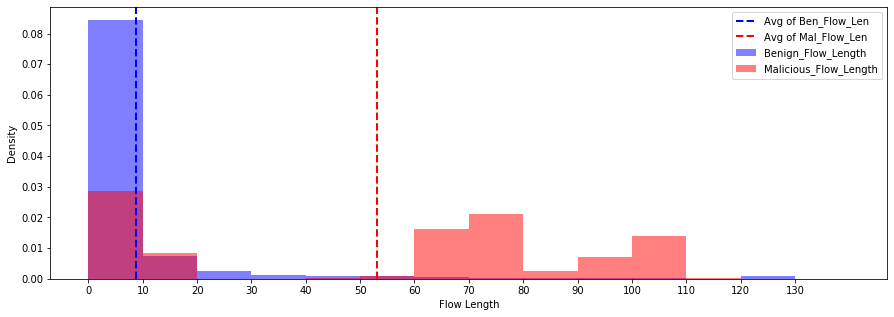

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.hist(ben_flow_len, bins = 14, alpha = 0.5, range = (0,140), density = True, color = 'b', label = 'Benign_Flow_Length')
plt.hist(mal_flow_len, bins = 14, alpha = 0.5, range = (0,140), density = True, color = 'r', label = 'Malicious_Flow_Length')
plt.xticks(np.arange(0,140,10))

plt.axvline(pd.DataFrame(ben_flow_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Flow_Len')
plt.axvline(pd.DataFrame(mal_flow_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Flow_Len')

plt.legend()
plt.xlabel('Flow Length')
plt.ylabel('Density')

In [71]:
ben_over_1000 = 0
for i in tqdm(range(len(ben_pck_len))):
    if ben_pck_len[i] > 1000:
        ben_over_1000 +=1

100%|██████████| 25304842/25304842 [00:07<00:00, 3451995.06it/s]


In [72]:
mal_over_1000 = 0
for i in tqdm(range(len(mal_pck_len))):
    if mal_pck_len[i] > 1000:
        mal_over_1000 +=1

100%|██████████| 3126872/3126872 [00:01<00:00, 2923608.13it/s]


In [73]:
print(f'Percentage of Benign Packet Length Over 1000: {100 *ben_over_1000/len(ben_pck_len):.4f}%')

Percentage of Benign Packet Length Over 1000: 0.1465%


In [74]:
print(f'Percentage of Malicious Packet Length Over 1000: {100 *mal_over_1000/len(mal_pck_len):.4f}%')

Percentage of Malicious Packet Length Over 1000: 0.1134%


In [75]:
print(f'Average of Benign Packet Length : {pd.DataFrame(ben_pck_len).mean()}')

Average of Benign Packet Length : 0    78.064581
dtype: float64


In [76]:
print(f'Average of Malicious Packet Length : {pd.DataFrame(mal_pck_len).mean()}')

Average of Malicious Packet Length : 0    105.33544
dtype: float64


Text(0, 0.5, 'Density')

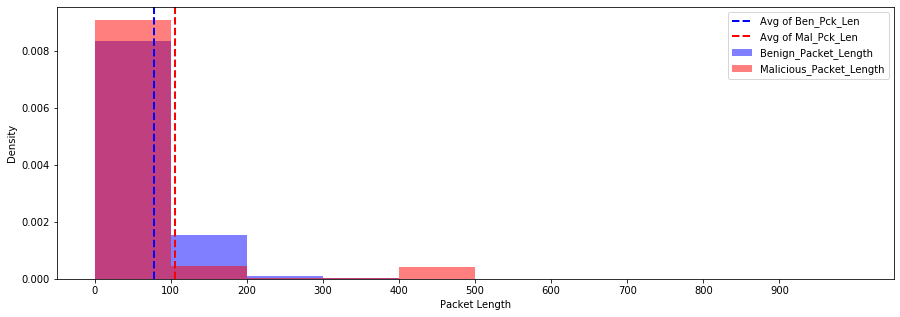

In [77]:
plt.figure(figsize = (15,5))

plt.hist(ben_pck_len, bins = 10, alpha = 0.5, range = (0,1000), density = True, color = 'b', label = 'Benign_Packet_Length')
plt.hist(mal_pck_len, bins = 10, alpha = 0.5, range = (0,1000), density = True, color = 'r', label = 'Malicious_Packet_Length')
plt.xticks(np.arange(0,1000,100))

plt.axvline(pd.DataFrame(ben_pck_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Pck_Len')
plt.axvline(pd.DataFrame(mal_pck_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Pck_Len')

plt.legend()

plt.xlabel('Packet Length')
plt.ylabel('Density')